In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
%cd '/content/drive/MyDrive/DATA 245/Project'

/content/drive/.shortcut-targets-by-id/1dBaisw15vXAkSJcnz0pO83MeXqW6AHFn/DATA 245/Project


In [4]:

file_path = '02 artifacts/processed_dataset_WQ.pkl'

try:
    df = pd.read_pickle(file_path)
    print(f"Successfully read '{file_path}'")


    if 'sample_date' in df.columns:
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        df = df.set_index('sample_date').sort_index()

    target_col = 'DissolvedOxygen_mg/L'
    feature_cols = ['SpecificConductance_µS/cm', 'Turbidity_NTU', 'WaterTemperature_°C', 'pH_pH units']

    data = df[[target_col] + feature_cols].copy()

    display(data.head())

except FileNotFoundError:
    print(f"File not found at {file_path}.")

Successfully read '02 artifacts/processed_dataset_WQ.pkl'


,DissolvedOxygen_mg/L,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units
sample_date,,,,,
2000-01-03 09:55:00,11.5,182.0,5.98,8.8,7.5
2000-01-03 10:55:00,11.5,55.0,2.80,9.5,8.0
2000-01-03 11:35:00,11.6,486.0,15.40,9.1,7.9
2000-01-03 12:40:00,11.2,167.0,8.45,9.7,7.9
2000-01-04 10:45:00,4.0,949.0,49.30,8.7,6.8


Daily Resampled Data: 5393 records ending on 2025-07-08
Training models for 15-day forecast loop... 

--- Last 15 Days History & Next 15 Days Forecast ---


,Value,Type,Lower_Bound,Upper_Bound
sample_date,,,,
2025-06-03,8.020000,History,NaN,NaN
2025-06-04,6.918000,History,NaN,NaN
2025-06-05,8.673333,History,NaN,NaN
2025-06-10,7.590000,History,NaN,NaN
2025-06-11,8.336667,History,NaN,NaN
2025-06-17,10.219417,History,NaN,NaN
2025-06-18,8.042857,History,NaN,NaN
2025-06-19,8.504000,History,NaN,NaN
2025-06-23,8.860000,History,NaN,NaN


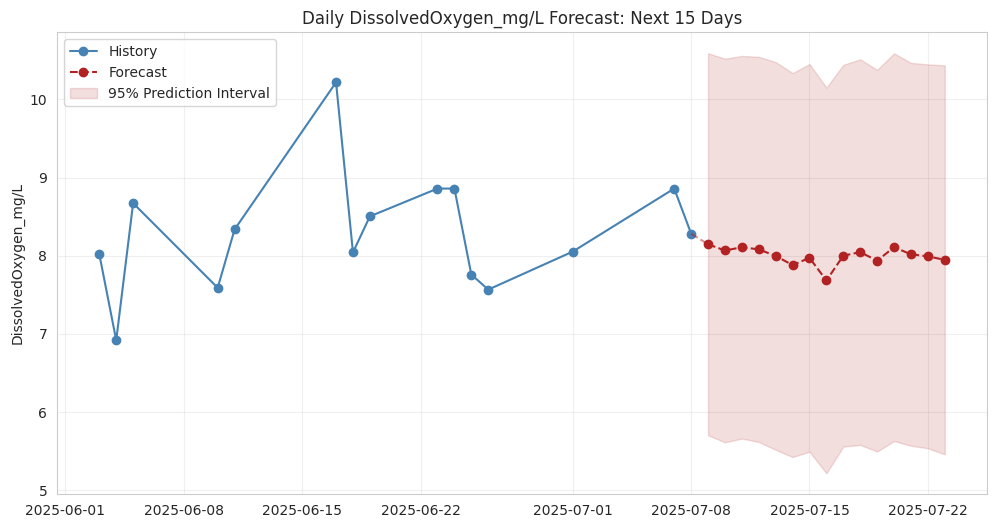

In [9]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. Resample to Daily Frequency
# This ensures that a lag of 1 corresponds to 1 Day, not 1 row (which might be minutes)
df_daily = df[[target_col] + feature_cols].resample('D').mean().dropna()
print(f"Daily Resampled Data: {len(df_daily)} records ending on {df_daily.index.max().date()}")

# 2. Configuration
forecast_horizons = range(1, 16)  # Predict Day +1 to Day +15
forecast_results = []

# History: Get last 15 days of actuals
history_df = df_daily.iloc[-15:].copy()
history_df['Type'] = 'History'
history_df['Lower_Bound'] = np.nan
history_df['Upper_Bound'] = np.nan
history_df = history_df[[target_col, 'Type', 'Lower_Bound', 'Upper_Bound']].rename(columns={target_col: 'Value'})

# 3. Train & Predict for each Horizon (Direct Strategy)
print("Training models for 15-day forecast loop... ")
latest_vals = df_daily.iloc[[-1]]  # The data at time 't'

for h in forecast_horizons:
    # --- A. Prepare Training Data (Shift by h days) ---
    temp_df = df_daily.copy()
    train_features = []

    for col in feature_cols:
        lag_col = f"{col}_lag_{h}"
        temp_df[lag_col] = temp_df[col].shift(h)
        train_features.append(lag_col)

    # Simple Seasonality
    temp_df['sin'] = np.sin(2 * np.pi * temp_df.index.dayofyear / 365.25)
    temp_df['cos'] = np.cos(2 * np.pi * temp_df.index.dayofyear / 365.25)
    train_features.extend(['sin', 'cos'])

    temp_df = temp_df.dropna()

    # --- B. Split & Train ---
    # Use last 20% for validation to estimate error (RMSE) for intervals
    split_idx = int(len(temp_df) * 0.8)
    train_set = temp_df.iloc[:split_idx]
    test_set = temp_df.iloc[split_idx:]

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, n_jobs=-1)
    model.fit(train_set[train_features], train_set[target_col])

    # --- C. Calculate Confidence Bounds (RMSE) ---
    preds_test = model.predict(test_set[train_features])
    rmse = np.sqrt(mean_squared_error(test_set[target_col], preds_test))

    # --- D. Predict Future Step ---
    # To predict t+h, we use inputs from t (which is 'latest_vals')
    future_date = latest_vals.index[0] + pd.Timedelta(days=h)
    input_row = pd.DataFrame(index=[future_date])

    for col in feature_cols:
        # Map current value to the lag column expected by the model
        input_row[f"{col}_lag_{h}"] = latest_vals[col].values[0]

    input_row['sin'] = np.sin(2 * np.pi * future_date.dayofyear / 365.25)
    input_row['cos'] = np.cos(2 * np.pi * future_date.dayofyear / 365.25)

    pred_val = model.predict(input_row[train_features])[0]

    forecast_results.append({
        'sample_date': future_date,
        'Value': pred_val,
        'Type': 'Forecast',
        'Lower_Bound': pred_val - 1.96 * rmse,  # Approx 95% CI
        'Upper_Bound': pred_val + 1.96 * rmse
    })

# 4. Consolidate
forecast_df = pd.DataFrame(forecast_results).set_index('sample_date')
full_df = pd.concat([history_df, forecast_df])

# Display Table
print("\n--- Last 15 Days History & Next 15 Days Forecast ---")
display(full_df)

# 5. Visualization
plt.figure(figsize=(12, 6))

# History
plt.plot(full_df[full_df['Type']=='History'].index, full_df[full_df['Type']=='History']['Value'],
         label='History', color='steelblue', marker='o')

# Forecast
f_data = full_df[full_df['Type']=='Forecast']
plt.plot(f_data.index, f_data['Value'], label='Forecast', color='firebrick', marker='o', linestyle='--')

# Connect lines
last_hist = full_df[full_df['Type']=='History'].iloc[-1]
first_fore = f_data.iloc[0]
plt.plot([last_hist.name, first_fore.name], [last_hist['Value'], first_fore['Value']],
         color='firebrick', linestyle='--', alpha=0.5)

# Confidence Intervals
plt.fill_between(f_data.index, f_data['Lower_Bound'], f_data['Upper_Bound'],
                 color='firebrick', alpha=0.15, label='95% Prediction Interval')

plt.title(f"Daily {target_col} Forecast: Next 15 Days")
plt.ylabel(target_col)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Calculating error metrics for horizons 1 to 15 on validation set...

--- Model Performance Metrics by Horizon ---


,RMSE,MAE,MAPE (%),R2
Horizon (Days),,,,
1,1.246981,0.958309,10.570473,0.050773
2,1.252327,0.962623,10.606487,0.042616
3,1.249045,0.957381,10.540488,0.046545
4,1.257119,0.968095,10.651850,0.034178
5,1.265724,0.976207,10.728732,0.020910
6,1.253302,0.971502,10.672851,0.040033
7,1.265423,0.979196,10.743212,0.021375
8,1.259017,0.972927,10.681005,0.030446
9,1.246342,0.965677,10.644393,0.049870



--- Average Metrics across 15 Days ---


,0
RMSE,1.255907
MAE,0.969269
MAPE (%),10.666162
R2,0.035891


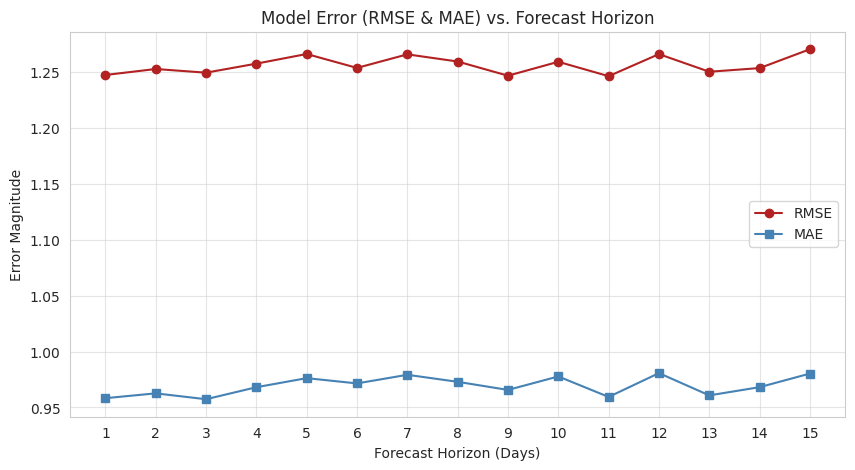

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics_results = []

print("Calculating error metrics for horizons 1 to 15 on validation set...")

for h in range(1, 16):
    # --- Re-create the specific dataset for this horizon ---
    temp_df = df_daily.copy()
    train_features = []

    for col in feature_cols:
        lag_col = f"{col}_lag_{h}"
        temp_df[lag_col] = temp_df[col].shift(h)
        train_features.append(lag_col)

    # Seasonality
    temp_df['sin'] = np.sin(2 * np.pi * temp_df.index.dayofyear / 365.25)
    temp_df['cos'] = np.cos(2 * np.pi * temp_df.index.dayofyear / 365.25)
    train_features.extend(['sin', 'cos'])

    temp_df = temp_df.dropna()

    # --- Split (same 80/20 split as before) ---
    split_idx = int(len(temp_df) * 0.8)
    train_set = temp_df.iloc[:split_idx]
    test_set = temp_df.iloc[split_idx:]

    # --- Train ---
    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, n_jobs=-1)
    model.fit(train_set[train_features], train_set[target_col])

    # --- Predict & Evaluate ---
    preds = model.predict(test_set[train_features])
    actuals = test_set[target_col]

    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mae = mean_absolute_error(actuals, preds)
    r2 = r2_score(actuals, preds)

    # Avoid division by zero for MAPE
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
        mape = np.nan_to_num(mape) # Replace inf/nan if actuals were 0

    metrics_results.append({
        'Horizon (Days)': h,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R2': r2
    })

metrics_df = pd.DataFrame(metrics_results).set_index('Horizon (Days)')

print("\n--- Model Performance Metrics by Horizon ---")
display(metrics_df)

print("\n--- Average Metrics across 15 Days ---")
display(metrics_df.mean())

# --- Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['RMSE'], marker='o', label='RMSE', color='firebrick')
plt.plot(metrics_df.index, metrics_df['MAE'], marker='s', label='MAE', color='steelblue')
plt.xlabel('Forecast Horizon (Days)')
plt.ylabel('Error Magnitude')
plt.title('Model Error (RMSE & MAE) vs. Forecast Horizon')
plt.legend()
plt.grid(True, alpha=0.5)
plt.xticks(range(1, 16))
plt.show()